# Import Libraries and Data

In [51]:
# ## This cell is exclusively for checking to see if you are using your GPU as TF's hardware accelerator

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
## If using Google Colab, use this code to upload data file to Google Collab from the local drive

from google.colab import files
uploaded = files.upload()

Saving eth.csv to eth.csv


In [3]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
# plt.style.use('dark_background')

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_dark'

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('eth.csv')
# df = pd.read_csv('data/eth.csv') ## This is the code for Jupyter Notebook/VSCode 
print(df.shape)
df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



(2134, 7)


Date      Open_  ...           Volume         MarketCap
0     Jun 08, 2021  $2,594.60  ...  $41,909,736,778  $292,557,075,207
1     Jun 07, 2021  $2,713.05  ...  $30,600,111,277  $300,985,400,826
2     Jun 06, 2021  $2,629.75  ...  $25,311,639,414  $315,453,931,558
3     Jun 05, 2021  $2,691.62  ...  $30,496,672,724  $305,598,725,249
4     Jun 04, 2021  $2,857.17  ...  $34,173,841,611  $312,256,566,095
...            ...        ...  ...              ...               ...
2129  Aug 10, 2015      $0.71  ...         $405,283       $42,818,364
2130  Aug 09, 2015      $0.71  ...         $532,170       $42,399,574
2131  Aug 08, 2015      $2.79  ...         $674,188       $45,486,894
2132  Aug 07, 2015      $2.83  ...         $164,329      $166,610,555
2133  Jun 09, 2021  $2,510.20  ...  $36,075,832,186  $303,147,462,062

[2134 rows x 7 columns]

# Goal and Data Description

## Goal

The goal of this project is to create a model that predicts prices that allow for successful day-trading. I want to make sure that the model predicts one day ahead, and that the culmination of all of these predictions follows the general trend of the actual prices, in order to allow day traders to make proper predictions to maximize profit or minimize loss.

## Data Source

This data was scraped from CoinMarketCap.com using the webscraper Octoparse. The webpages used ajax syntax for the "load page" button, and therfore ajax timeout time needed to be applied in order to properly extract the data. This data is only concerned with Ethereum, and no other coin or blockchain.

## Features

The data includes the following features:

1. Open
2. High
3. Low
4. Close 
5. Volume
6. Market Cap
<br>

This dataset provides a timeline of Ethereum prices and related data from August 7th, 2015 to June 8th, 2021.
<br>


# Data Preprocessing

In [4]:
# Convert the 'Date' column to a datetime datatype and set it as the index, then sort the index
df['Date'] = pd.to_datetime(df.Date)
df.set_index(df.Date, inplace=True)
df.drop(df.tail(1).index, inplace=True)
df = df.sort_index()

# Drop the Date column
df = df.drop(columns=['Date'], axis=1)

# Specify columns
cols = list(df.columns)

# Replace the dollar signs and commas with empty character
df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)

## Convert all entries to numerical data type
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Rename the columns with unconventinal text in the string
df.rename(columns={'Open_':'Open', 'Close__':'Close'}, inplace=True)

# Find missing values
print(df.isna().sum())

# There are very few missing values, so we will drop all of them
df = df.dropna()

# Check for duplicates in index
print(df.index.duplicated().sum())

# Check for duplicates in columns
print(df.duplicated().sum())

# Check how much of the data are duplicates overall
print(df[df.duplicated()==True].shape[0] / df.shape[0])

# There are no duplicates but let's use the drop_duplciates method just as good practice
df = df.drop_duplicates()
print(df.shape)
df.info()

Open         0
High         0
Low          0
Close        0
Volume       0
MarketCap    0
dtype: int64
0
0
0.0
(2133, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2133 entries, 2015-08-07 to 2021-06-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2133 non-null   float64
 1   High       2133 non-null   float64
 2   Low        2133 non-null   float64
 3   Close      2133 non-null   float64
 4   Volume     2133 non-null   int64  
 5   MarketCap  2133 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 116.6 KB


# EDA

### Original Time Series Visualizations

Let's take a look at the time series.

In [ ]:
# Import graph objects
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
for c in list(df.columns):
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig

### Histograms

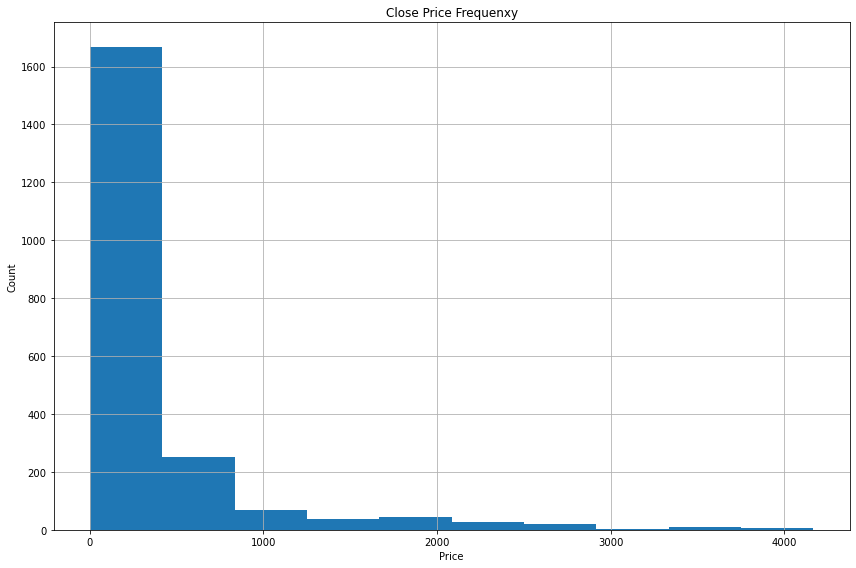

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
df.hist(column=['Close'], ax=ax)
ax.set_title('Close Price Frequenxy')
ax.set_xlabel('Price')
ax.set_ylabel('Count')
plt.tight_layout()
# plt.savefig('Histograms')


Above is a histogram of the frequency of occurences of price value. Their distribution exemplifies the volatility of the asset. The large majority of prices fall between 0 and 1000, however there are low-frequency instances of prices that are 2, 3, and 4 times the max value of that range. This shows that the price spiked and fell, never maintaining a high value for very long at all. 

### Clean up the Graphs

The original time series was very hard to interpret because the volume column has very large numbers that messed with the scale of the graph. In order to remedy this, we will plot the price data and the volume data seperately, and we will resample the Volume data in order

In [ ]:
# Plot the time series
fig = go.Figure()
col = ['Open', 'High', 'Low', 'Close']

# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=df.index, y=df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price',
legend_title='Legend')
fig.show()
display(px.line(data_frame=df, x=df.index, y=df['Volume'], title='Volume Data'))

Target Variable

The trends of each series for each price related column (our target) are pretty much identical, so we can choose one of the features as a target variable and stick with that.
<br>

I will be using the "Close" price for Ethereum, which is the price of the asset at the close of normal trading hours at 4pm. 

### Resample Data (Week, Month, Year)

In [ ]:
# Create resampled DataFrame for more smooth visualization
quarterly_df = pd.DataFrame(df.resample('Q').mean())

# Plot the time series
fig = go.Figure()
col = ['Open', 'High', 'Low', 'Close']
# Add traces
for c in col:
    fig.add_trace(go.Scatter(x=quarterly_df.index, y=quarterly_df[c], mode='lines', name=f'{c}'))
fig.update_layout(
title='Price Data',
xaxis_title='Date',
yaxis_title='Price',
legend_title='Legend')
fig.show()
display(px.line(data_frame=quarterly_df, x=quarterly_df.index, y=quarterly_df['Volume'], title='Volume Data'))

### Autocorrelation Plots

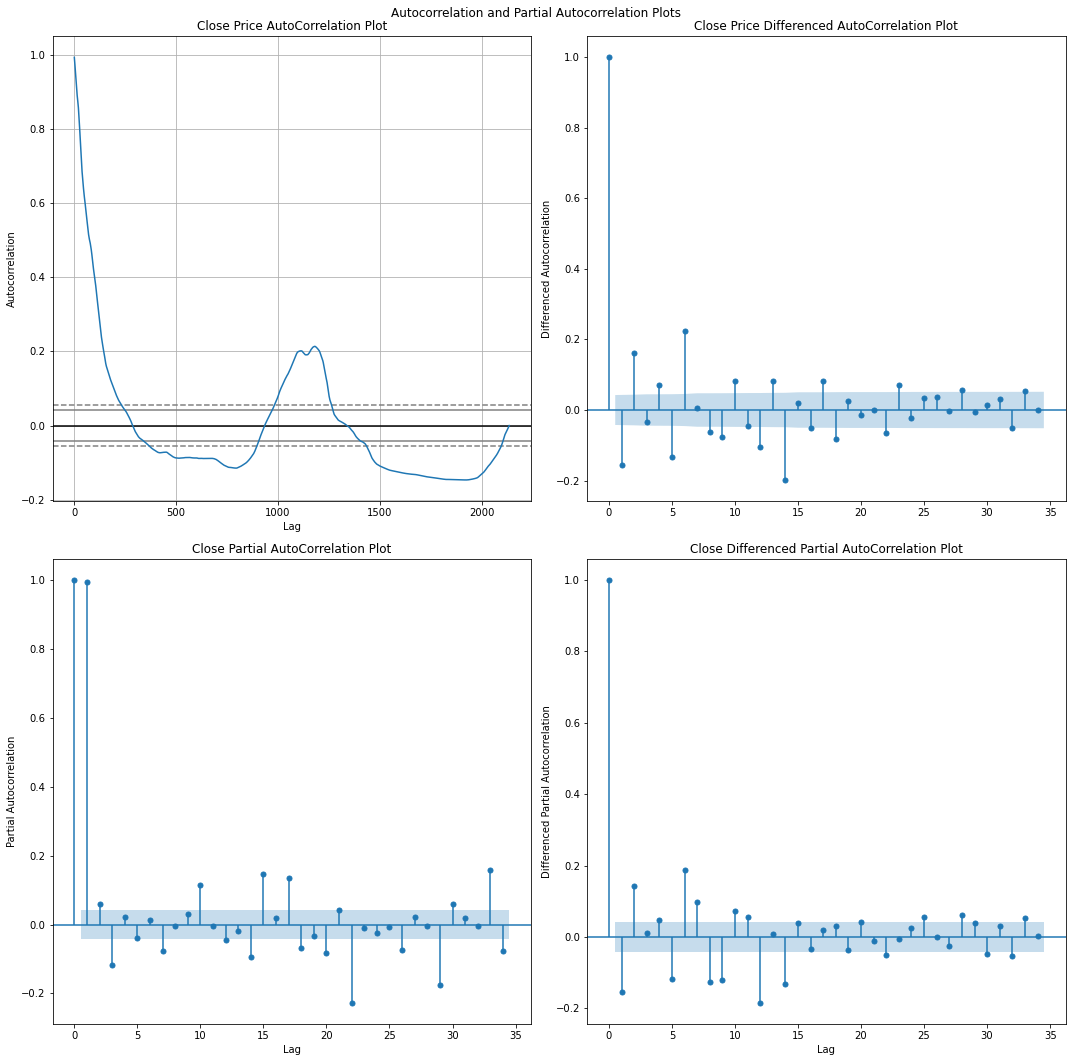

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

autocorrelation_plot(df['Close'].dropna(), ax=ax[0][0])
ax[0][0].set_title('Close Price AutoCorrelation Plot')

plot_acf(df['Close'].diff().dropna(), ax=ax[0][1])
ax[0][1].set_title('Close Price Differenced AutoCorrelation Plot')
ax[0][1].set_ylabel('Differenced Autocorrelation')

plot_pacf(df['Close'].dropna(), ax=ax[1][0])
ax[1][0].set_title('Close Partial AutoCorrelation Plot')
ax[1][0].set_xlabel('Lag')
ax[1][0].set_ylabel('Partial Autocorrelation')

plot_pacf(df['Close'].diff().dropna(), ax=ax[1][1])
ax[1][1].set_title('Close Differenced Partial AutoCorrelation Plot')
ax[1][1].set_xlabel('Lag')
ax[1][1].set_ylabel('Differenced Partial Autocorrelation')

plt.suptitle('Autocorrelation and Partial Autocorrelation Plots')
plt.tight_layout()
plt.savefig('acf_plots')

### Test Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF Test for Non-differenced target variable
result = adfuller(df['Close'], autolag='AIC')
print('NON-DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

print(' ')
print(' ')

# ADF Test for Differenced target variable
result = adfuller(df['Close'].diff().dropna(), autolag='AIC')
print('DIFFERENCED TARGET VARIABLE')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


NON-DIFFERENCED TARGET VARIABLE
ADF Statistic: 1.0029061147236595
p-value: 0.9942965169904011
 
 
DIFFERENCED TARGET VARIABLE
ADF Statistic: -9.300900887869764
p-value: 1.1132363356594116e-15


- A first-order difference is enough to stationarize the data

### Rolling Averages

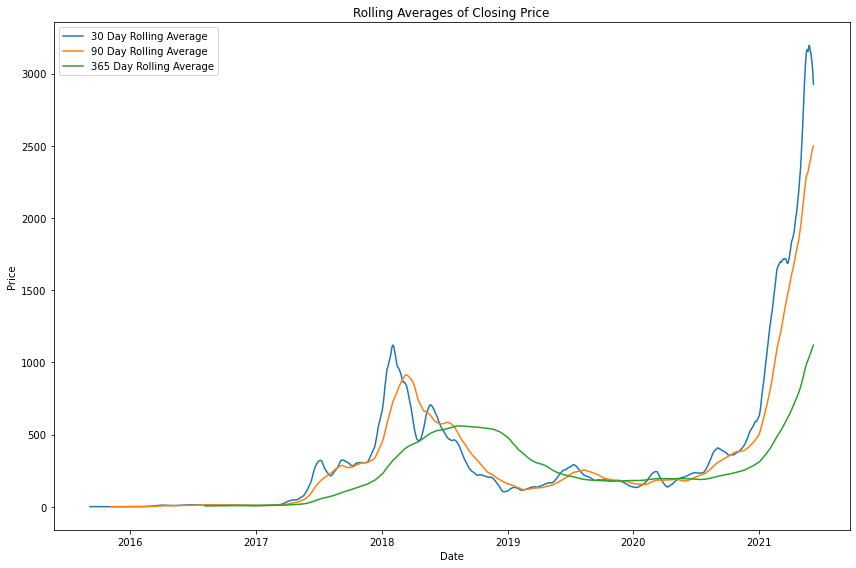

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
df_30d_rol = df['Close'].rolling(window = 30).mean()
df_90d_rol = df['Close'].rolling(window = 90).mean()
df_365d_rol = df['Close'].rolling(window = 365).mean()
ax.plot(df_30d_rol, label='30 Day Rolling Average')
ax.plot(df_90d_rol, label='90 Day Rolling Average')
ax.plot(df_365d_rol, label='365 Day Rolling Average')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Rolling Averages of Closing Price')
plt.legend()
plt.tight_layout()
plt.savefig('rolling_averages')

In [ ]:
# # Full compiled graph of 30-day, 90-day, and 365-day rolling averages

# fig = go.Figure()


# df_30d_rol = df['Close'].rolling(window = 30).mean()
# df_90d_rol = df['Close'].rolling(window = 90).mean()
# df_365d_rol = df['Close'].rolling(window = 365).mean()
# fig.add_trace(go.Scatter(x=df.index, y=df_30d_rol, mode='lines', name=f'30d Close'))
# fig.add_trace(go.Scatter(x=df.index, y=df_90d_rol, mode='lines', name=f'90d Close'))
# fig.add_trace(go.Scatter(x=df.index, y=df_365d_rol, mode='lines', name=f'365d Close'))

# fig.update_layout(
# title='Price Data',
# xaxis_title='Date',
# yaxis_title='Price',
# legend_title='Legend')
# fig.show()

The rolling averages calculated from three different windows (30, 90, 365) provide some more insight to the data. As the window increases in size, the rolling averages' values have very different values during the highly volatile periods of the price of Ethereum. This volatility resulted in each of these periods having wildly different minimum and maximum values, which results in rolling averages that also different by quite a lot. Unsurprisingly, the 30-day and 90-day rolling averages were the most closely related, especially during the first period of steep upwards trend. The prices did not reach magnitude differences during these windows that warranted such a drastic rolling average difference. However, at the end of our time period, the rolling averages end up differing in value by almost $500, which goes to show the extreme volatility that Ethereum experienced during this time period (the most recent months when Ethereum had a meteoric rise). In short summary, the 365-day moving average had the lowest average value because it generalized the most volatility, however its final value was very below the true price. The 30-day moving average had the highest value because it strongly accounted for the high volatility, and its final value was a little higher than the true price (the extreme upper values pulled the average upwards). The 90-day moving average was the closest to the true price, showing that it both accounted for and generalized the volatility the best of the three windows!

### Seasonality

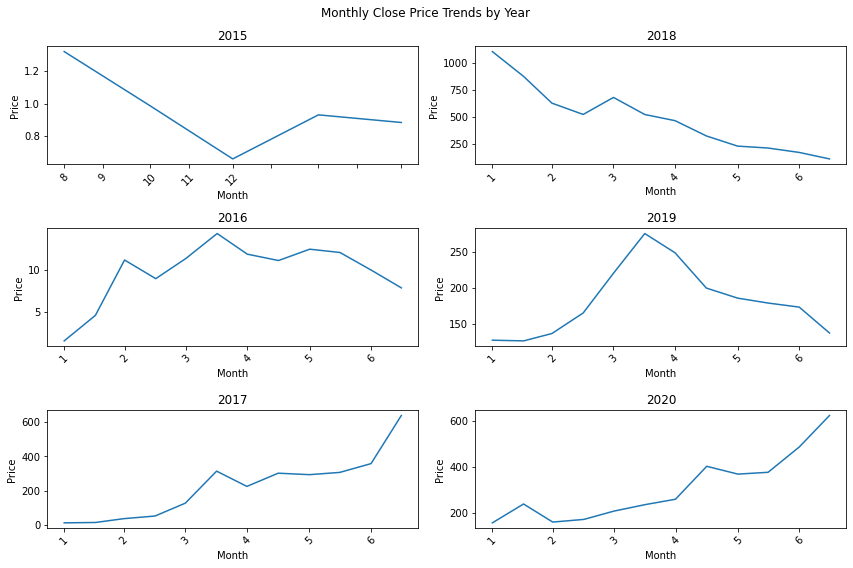

In [ ]:
# Investigate Monthly Seasonality per Year
monthly_df = pd.DataFrame(df.resample('MS').mean())
fig, ax = plt.subplots(3,2, figsize=(12, 8))

ax[0][0].plot(monthly_df['Close']['2015'])
ax[0][0].set_title('2015')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Price')
ax[0][0].set_xticklabels(labels=monthly_df['Close']['2015'].index.month,rotation=45)

ax[1][0].plot(monthly_df['Close']['2016'])
ax[1][0].set_title('2016')
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Price')
ax[1][0].set_xticklabels(labels=monthly_df['Close']['2016'].index.month,rotation=45)

ax[2][0].plot(monthly_df['Close']['2017'])
ax[2][0].set_title('2017')
ax[2][0].set_xlabel('Month')
ax[2][0].set_ylabel('Price')
ax[2][0].set_xticklabels(labels=monthly_df['Close']['2017'].index.month,rotation=45)


ax[0][1].plot(monthly_df['Close']['2018'])
ax[0][1].set_title('2018')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Price')
ax[0][1].set_xticklabels(labels=monthly_df['Close']['2018'].index.month,rotation=45)


ax[1][1].plot(monthly_df['Close']['2019'])
ax[1][1].set_title('2019')
ax[1][1].set_xlabel('Month')
ax[1][1].set_ylabel('Price')
ax[1][1].set_xticklabels(labels=monthly_df['Close']['2019'].index.month,rotation=45)


ax[2][1].plot(monthly_df['Close']['2020'])
ax[2][1].set_title('2020')
ax[2][1].set_xlabel('Month')
ax[2][1].set_ylabel('Price')
ax[2][1].set_xticklabels(labels=monthly_df['Close']['2020'].index.month,rotation=45)

plt.suptitle('Monthly Close Price Trends by Year')
plt.tight_layout()
plt.savefig('monthly_price_trends')

There are no seasonal trends shown. Each year shows varying periods of time where the price and volume experienced both upwards and downwards trends. Since 

### Findings

Ethereum prices follow what is called a "cyclical trend", which means that it has trends however these trends so no specific pattern of repetition. To illustrate this, we can look at two of the graphs, which are both displayed above. 

From the year 2015 to the first quarter of 2017, the price of Ethereum remained quite stationary, with a very strong rise starting between March and April, which led to a strong upwards trend that lasted throughout the rest of the year of 2017, bring the price to a maximum value of 826.82 by the end of the year. This constituted a 10,106 percent price increase from the minimum price of 8.17 in the year of 2017, which is by all standards a very strong upwards trend. The volume of trades also followed this trend quite closely, matching the sentiment idea that as an asset shoots up in price, more people attempt to join in on the ride, and hence more trades are made. After the year 2017, the price of Ethereum immediately started a strong downwards trend beginning in January of 2018, and by the end of 2018 the price had settled to a minimum value of 84.30, roughly a 94% drop from its all time high at the very beginning of 2018. Volume for the rest of 2018 remained on average higher than the two years afterwards and the year before because at first people were participating in frequent trades due to the meteoric rise in price, and then people continued to sell their coins over the year as the price tanked. From 2019 to mid-2020, the price once again mostly resumed the stationary trend that it had exemplified from 2015 to about a quarter of the way through 2017, indicating that perhaps people lost interest in the Ethereum block-chain, doubted its potential, or simply moved on to different investments. There was a sharp rise in prise to a little over 250 during 2019, but it just as quickly fell back to close to the minimum value of that year, failing to breakout of its strong downwards trend. The volume from 2019 to mid-2020 would never drop to the levels seen before the coin's meteoric rise, most likely because such a note-worthy event put Ethereum on the map permanently. During 2019, there was a sharp rise and fall in volume that mirrored the trend of the quick rise and fall of price during that year. 2019-2021 would be the period of time when Ethereum would consistently reflect a yearly upwards trend. Volume was higher than its ever been, and the price rose to an unprecedented level of roughly 4000. During this upwards trend, there were several downwards trends that occured during certain months of the years. They seemed to be relatively random, with no predictability in their occurences, highlighting the unstationarity of the price of Ethereum, and also the idea that the price follows a "cyclical trend". There are very clear bull and bear markets, however the trickly part is timing these.  



# Modeling

## Scale the Data

We are going to want to scale the data because of the massive magnitude differences between values. This will most likely improve the accuracy of our forecast

In [5]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
scaled_data = pd.DataFrame(ss.fit_transform(df), columns=df.columns, index=df.index)

## Prophet

In [30]:
### Import Prophet
from fbprophet import Prophet

### Create Prophet compatible DataFrame
data = df.reset_index()[['Date', 'Close', 'Volume', 'MarketCap']].rename(columns={'Date':'ds', 'Close':'y', 'Volume':'Volume', 'MarketCap':'MarketCap'})

### Train-Test-Split the data
train = data[:1407]
test = data[1407:]

First, Prophet will be used as a univariate regression model, with the sole determinant variable being our target variable, the "Close" price.

516.0354956048175


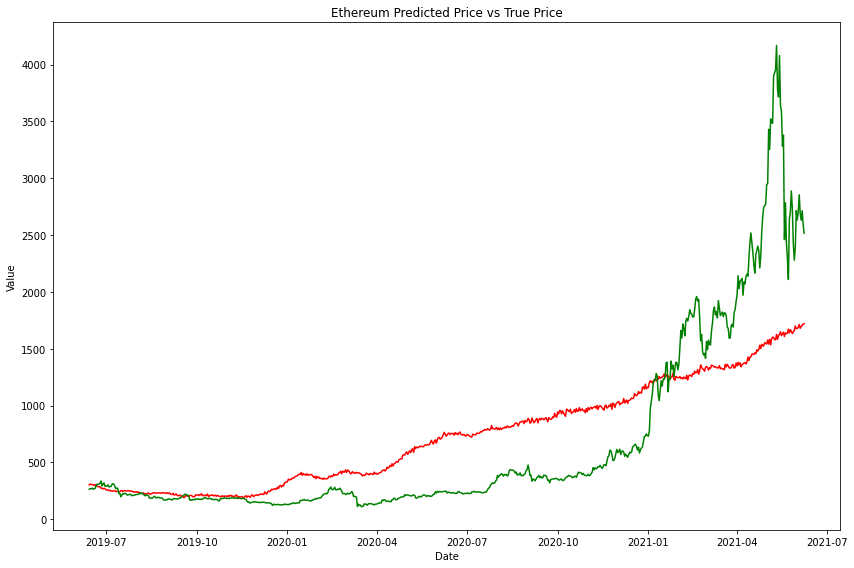

In [31]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

In [39]:
# ### Predictions using all data
# m = Prophet(daily_seasonality=False)
# m.fit(data)
# future = m.make_future_dataframe(periods=0, freq='D')
# forecast = m.predict(future)
# m.plot(forecast, xlabel='Date', ylabel='Value');

# ### Predictions DataFrame
# pred = pd.DataFrame(forecast.yhat_upper)
# pred.index=forecast.ds
# pred

# ### Test data DataFrame
# testplot = pd.DataFrame(data.y)
# testplot.index=data.ds

# ### RMSE
# import math
# rmse = math.sqrt(mean_squared_error(pred, testplot))
# print(rmse)

The univariate model had an RMSE of 505.761
To try and improve this model's performance, a second regressor variable will be added into the model's calculations. This will be the "Volume" data found in the same imported data as the "Close" prices.

514.912407537433


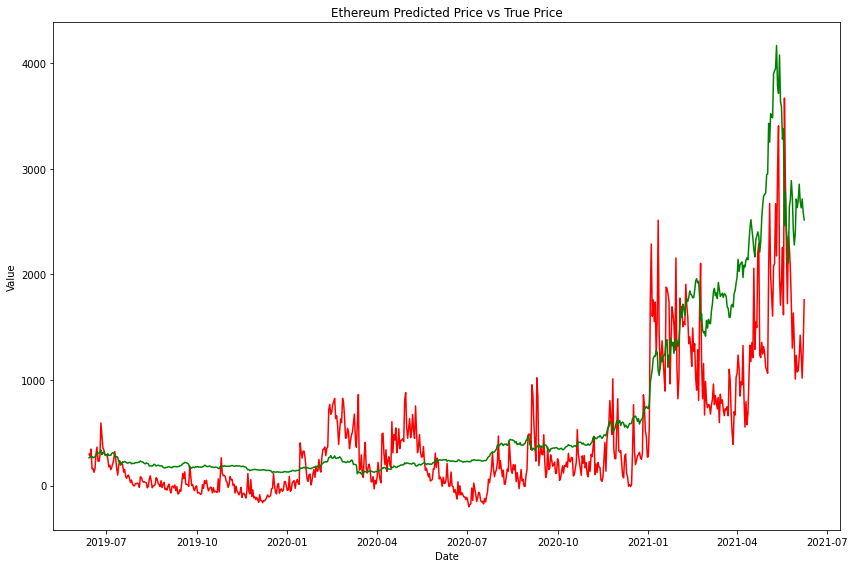

In [36]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

The RMSE of the new model was 505.584

Adding one additional regressor to the model seemed to improve its performance, but only ever so slightly. Let's add one more regressor to see if it can help improve the model. We will use another variable that was found in the imported data that cannot be directly derived from the price; "Market Cap"

276.25246373608405


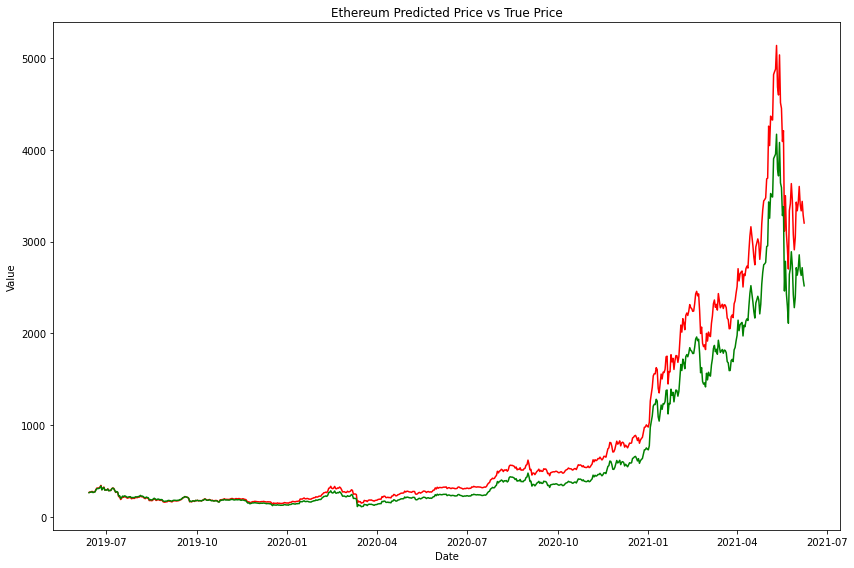

In [38]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.add_regressor('MarketCap')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
future['MarketCap'] = test['MarketCap'].values
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

The RMSE score for the model with two additional regressor variables was 276.252

Adding a second regressor improved our RMSE metric by a very considerable amount.

This begs the question; "Will adding one or two more regressors improve the model even further?"

Let's find out.

In order to do this, we will have to use new data imported from the same source as the original data used; CoinMarketCap.com



*   We will use BitCoin close prices on the corresponding dates as our third regressor variable.



In [ ]:
### Predictions using training data
m = Prophet(daily_seasonality=False)
m.add_regressor('Volume')
m.add_regressor('MarketCap')
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')[1407:]
future['Volume'] = test['Volume'].values
future['MarketCap'] = test['MarketCap'].values
# future['Bitcoin_Close'] = test['Close']  ### HAVE TO SCRAPE BITCOIN DATA FOR THIS!!!
forecast = m.predict(future)


### Predictions DataFrame
pred = pd.DataFrame(forecast.yhat_upper[-726:])
pred.index=forecast.ds[-726:]
pred

### Test data DataFrame
testplot = pd.DataFrame(test.y)
testplot.index=test.ds

### Plot Test vs Predictions
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pred, label='Predictions', color='red')
ax.plot(testplot, label='True', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Ethereum Predicted Price vs True Price')
plt.tight_layout()

### Calculate RMSE
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred, testplot))

# display(future)
# display(pred)
print(rmse)

## Random-Walk

In [ ]:
## Walk
rwdata = pd.DataFrame(df['Close'], columns=['Close'])
rwdata['change'] = df['Close'].pct_change()
mean = rwdata['change'][1:].mean() 
sd = rwdata['change'][1:].std()

## Predict
model = {}
model['Prediction'] = [rwdata['Close'][0]]
for time in range(1, len(rwdata)):
    old = model['Prediction'][time -1] 
    new_price = old*(1+ mean) + old*sd*np.random.normal(0,1) 
    model['Prediction'].append(new_price)
    
## Plot
rwdf = pd.DataFrame(model, index=rwdata.index) 

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rwdf, label='Predicted Values', color='Red')
ax.plot(rwdata['Close'], label='True Values', color='Blue')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Random Walk Predictions vs True Value')
plt.legend()
plt.tight_layout()

rmse = math.sqrt(mean_squared_error(rwdf, rwdata['Close']))
print(f'RMSE = {rmse}')

The model was run multiple times, in an attempt to aquire the best possible model for the problem. The best random-walk achieved had an RMSE of 323.097. Since the business strategy we are focusing on is day-trading, it is preferable to have tighter margins of error, because we are not holding for long periods of time and therefore a wrong guess affects our success more strongly.

## ARIMA Model

In [ ]:
### Train-Test-Split the Non-Scaled Data
y_train = df['Close'][:'2019-06-13']
y_test = df['Close']['2019-06-14':] 
x_train = df.index[:1407]
x_test = df.index[1407:]

###
y_train_scaled = scaled_data['Close'][:'2019-06-13']
y_test_scaled = scaled_data['Close']['2019-06-14':] 

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA

# Build a 1,1,1 ARIMA model
p, d, q = 1, 1, 1
model = ARIMA(y_train, order=(p, d, q))
model_fit = model.fit()


### Model Summary
print(model_fit.summary())


### Forecast
forecast, se, conf = model_fit.forecast(3, alpha=0.05)


### Convert to series so we can plot the data
forecast_series = pd.Series(forecast, index=y_test.index)


### Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label='Training')
plt.plot(y_test, label='Actual')
plt.plot(forecast_series, label='Model Predictions')
plt.title('Forecast vs Actual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('arima')

rmse = math.sqrt(mean_squared_error(forecast_series, y_test))
print(f' RMSE = {rmse}')

In [ ]:
# Calculate Residuals
residuals = pd.DataFrame(model_fit.resid)

# Plot residuals
fig, ax = plt.subplots(1,2, figsize=(18,10))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.tight_layout()

The ARIMA model performed poorly for the data provided. This can almost certainly be attributed to the exaggerated volatility of Ethereum prices. The period of time that ARIMA was trained on showed an interesting trend. The price remained low, then spiked to a value that was much higher than before, and just as quickly fell down to a very low value again and remained there for quite some time. In other words, it was relatively stationary, then had a steep upwards trend, a steep downwards trend, and then remained relatively stationary again. The two main determinants of ARIMA predicitons, past values and moving average, are very hard to predict upon because thei values vary by so much. In order to try and improve my model, I will be using the "pmdarima" package to try and optimize the hyperparamters of the ARIMA model.

The RMSE of the model was 915.88, a very poor metric, and significantly worse than our random-walk metric measurement.

## Auto-ARIMA

In [ ]:
import pmdarima as pm
model = pm.auto_arima(y_train, start_P=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                      D=1, start_Q=0, max_D=5, max_Q=5, m=12, seasonal=True, error_action='warn',
                      trace=True, supress_warnings=True, stepwise=False)
model.summary()

In [ ]:
# make your forecasts
prediction = pd.DataFrame(model.predict(n_periods=726), index=y_test.index)
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y_test.shape[0])
plt.plot(y_train, c='green')
plt.plot(prediction, c='pink')
plt.show()

rmse = math.sqrt(mean_squared_error(prediction, y_test))
print(f'RMSE = {rmse}')

The AUTO-ARIMA model was ran and forecasted. It performed marginally better than the ARIMA model, with an RMSE of 915.55 rather than an RMSE of 915.88. This value is still significant worse than the metric calculated from our Random-Walk model. Since these metrics are so poor, we are going to move on to different model.

## Deep Learning

### LSTM

In [5]:
data = np.asarray(df['Close']).reshape(-1,1)

In [6]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# split into train and test sets
train_size = int(len(data) * 0.6)
test_size = len(data) - train_size

train = data[0:train_size,:]
test = data[train_size:len(data),:]

In [7]:
# Use TimeseriesGenerator to create the samples
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 90

train_data = TimeseriesGenerator(train, train,
    length=n_input,
    batch_size=128)

test_data = TimeseriesGenerator(test, test,
    length=n_input,
    batch_size=1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf

In [9]:
np.asarray(train_data).shape

(10, 2)

In [ ]:
from numpy.random import seed

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 [==============================] - 2s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/200
10/10 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 5/200
10/10 [==============================] - 0s 9ms/step - loss: 

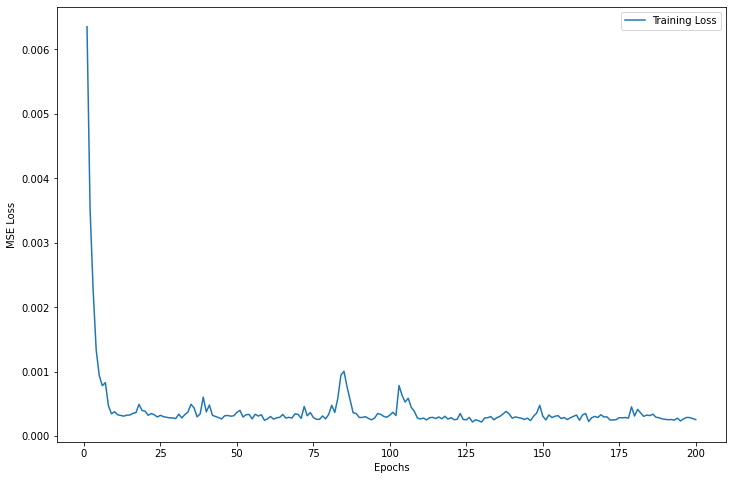

(1189, 1)
(764, 1)


Close         Pred
Date                            
2019-05-07   169.80   168.250092
2019-05-08   170.95   168.991013
2019-05-09   170.29   169.895798
2019-05-10   173.14   170.630081
2019-05-11   194.30   171.732788
...             ...          ...
2021-06-04  2688.19  2063.016357
2021-06-05  2630.58  2056.518555
2021-06-06  2715.09  2051.236816
2021-06-07  2590.26  2059.212646
2021-06-08  2517.44  2049.517090

[764 rows x 2 columns]

RMSE = 257.1666569081962


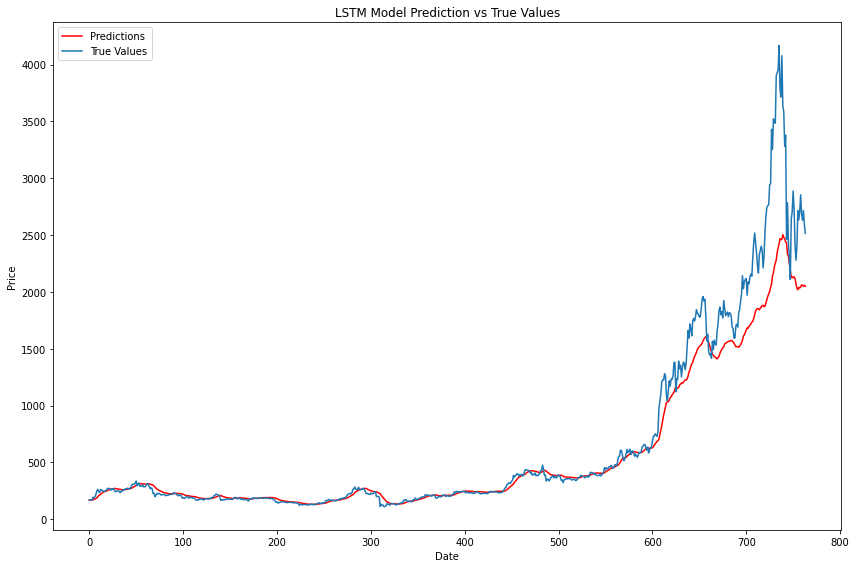

In [ ]:
# Model 1

model1 = Sequential()
model1.add(LSTM(256, return_sequences=False,
                  input_shape=(10,2), dropout=0.2))
# model1.add(Dropout(0.2))
model1.add(Dense(units=1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model1.summary()
history = model1.fit_generator(train_data, epochs=200)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, 201)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model1.predict_generator(train_data)
test_pred = model1.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df1 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df1['Pred'] = test_pred
display(rmse_df1)
rmse = math.sqrt(mean_squared_error(rmse_df1['Close'], rmse_df1['Pred']))
print(f'RMSE = {rmse}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               41200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 17s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 4/100
10/10 [==============================] - 0

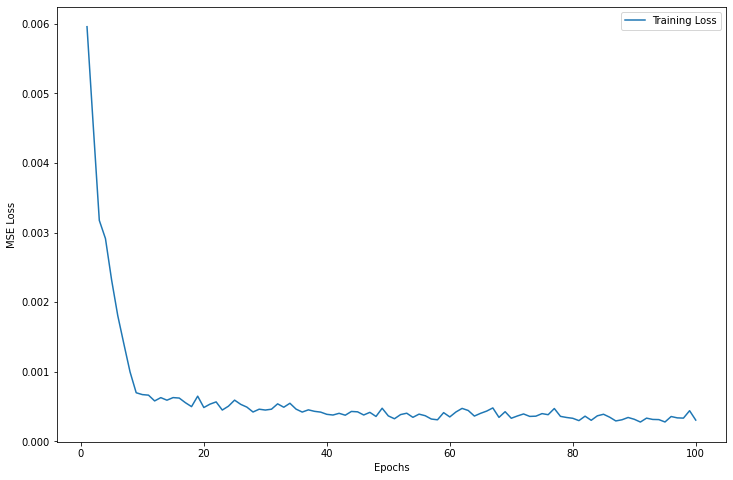

(1189, 1)
(764, 1)


Close         Pred
Date                            
2019-05-07   169.80   181.398193
2019-05-08   170.95   182.378159
2019-05-09   170.29   183.372009
2019-05-10   173.14   184.149673
2019-05-11   194.30   185.162949
...             ...          ...
2021-06-04  2688.19  2075.068604
2021-06-05  2630.58  2083.063721
2021-06-06  2715.09  2081.623779
2021-06-07  2590.26  2087.803223
2021-06-08  2517.44  2079.524902

[764 rows x 2 columns]

RMSE = 243.98228487057352


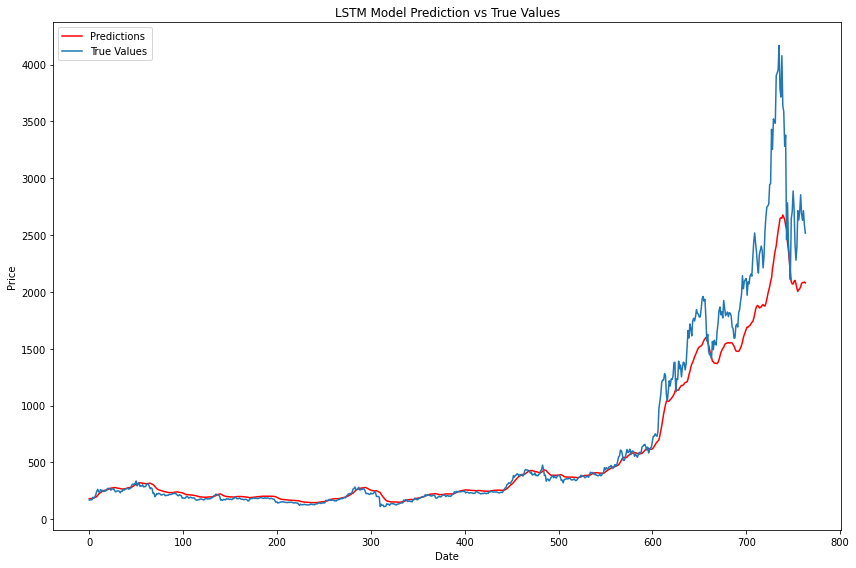

In [ ]:
# Model 2

model2 = Sequential()
model2.add(LSTM(100, return_sequences=False,
                  input_shape=(10,2), dropout=0.2))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model2.summary()
history = model2.fit_generator(train_data, epochs=100)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, 101)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model2.predict_generator(train_data)
test_pred = model2.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df2 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df2['Pred'] = test_pred
display(rmse_df2)
rmse = math.sqrt(mean_squared_error(rmse_df2['Close'], rmse_df2['Pred']))
print(f'RMSE = {rmse}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 19, 100)           41200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 202,101
Trainable params: 202,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
10/10 [==============================] - 5s 22ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 2/30
10/10 [==============================] - 0s 24ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 3/30
10/10 [==========

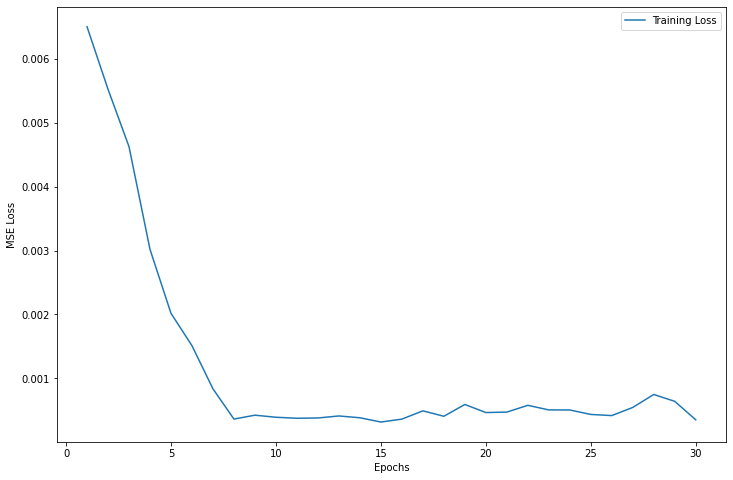

(1189, 1)
(764, 1)


Close         Pred
Date                            
2019-05-07   169.80   148.595856
2019-05-08   170.95   149.117401
2019-05-09   170.29   149.818878
2019-05-10   173.14   150.615631
2019-05-11   194.30   151.500504
...             ...          ...
2021-06-04  2688.19  2300.212646
2021-06-05  2630.58  2306.293213
2021-06-06  2715.09  2313.573975
2021-06-07  2590.26  2321.925537
2021-06-08  2517.44  2328.070068

[764 rows x 2 columns]

RMSE = 203.29000390390036


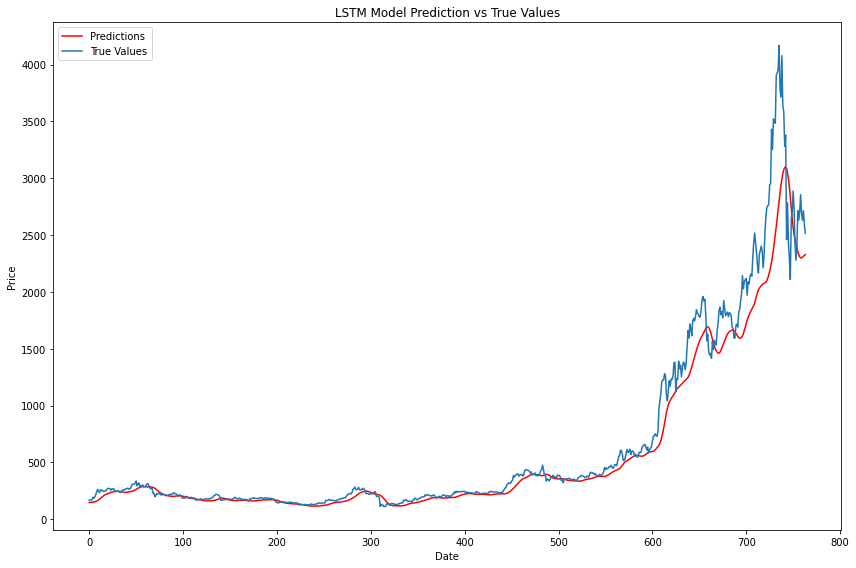

In [ ]:
# Model 3 (Greater complexity, dropout is specified inside the LSTM model parameters)
# Read this https://stackoverflow.com/questions/50720670/using-dropout-with-keras-and-lstm-gru-cell to understand the difference
## between a dropout LAYER and the dropout PARAMETER in the LSTM function

# Create the model!
model3 = Sequential()
model3.add(LSTM(units=100, return_sequences=True,
                  input_shape=(19,2), dropout=0.2))
model3.add(LSTM(units=100, return_sequences=True,
                  dropout=0.2))
model3.add(LSTM(units=100, dropout=0.2))
model3.add(Dense(units=1))

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model3.summary()

# Run the model
history = model3.fit_generator(train_data, epochs=30)

# Predict the data using the model!
train_pred = model3.predict_generator(train_data)
test_pred = model3.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Plot loss per epoch
loss = history.history['loss']
epochs = range(1, 31)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df3 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df3['Pred'] = test_pred
display(rmse_df3)
rmse = math.sqrt(mean_squared_error(rmse_df3['Close'], rmse_df3['Pred']))
print(f'RMSE = {rmse}')

Originally, 30 epochs were used for the model. The "Loss vs Epoch" graph suggested that the loss could further be reduced, as it still had a clear downward trend rather than evening out in order to show the values of the loss converged.

For the next model, we will use the same complexity model, however we will increase the number of epochs to 100.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 90, 128)           66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 90, 128)           131584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 218,785
Trainable params: 218,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 5s 22ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 3/100
10/10 [=======

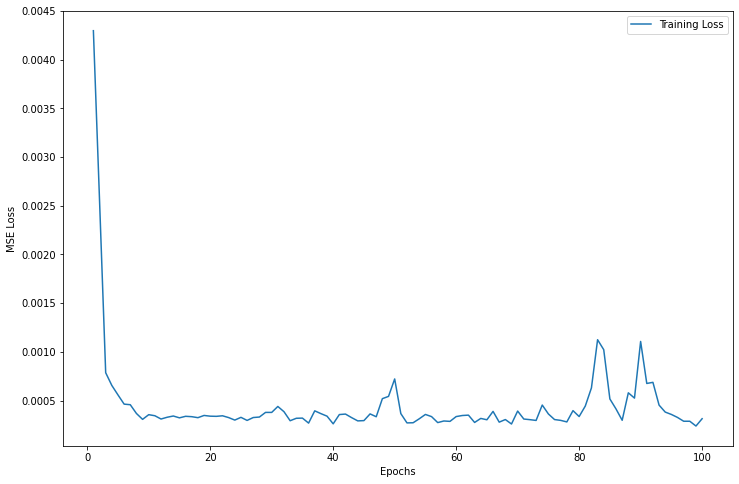

(1189, 1)
(764, 1)


Close         Pred
Date                            
2019-05-07   169.80   163.877274
2019-05-08   170.95   164.675751
2019-05-09   170.29   165.496292
2019-05-10   173.14   166.208771
2019-05-11   194.30   166.997711
...             ...          ...
2021-06-04  2688.19  2208.114014
2021-06-05  2630.58  2216.413818
2021-06-06  2715.09  2213.385742
2021-06-07  2590.26  2211.163818
2021-06-08  2517.44  2202.012451

[764 rows x 2 columns]

RMSE = 216.69772106369058


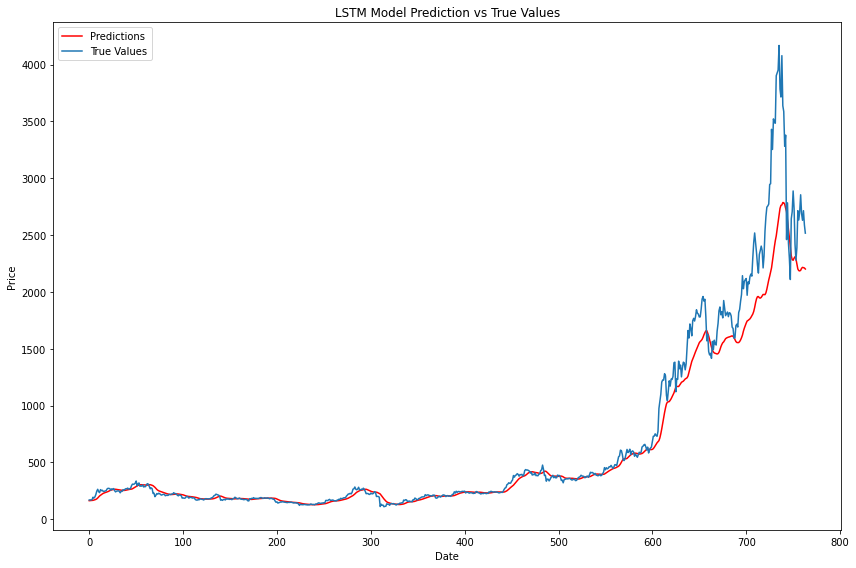

In [ ]:
# Model 4 (same model, more epochs)

# Create the model!
model4 = Sequential()
model4.add(LSTM(units=128, return_sequences=True,
                  input_shape=(90,1), dropout=0.2))
model4.add(LSTM(units=128, return_sequences=True,
                  dropout=0.2))
model4.add(LSTM(units=32, dropout=0.2))
model4.add(Dense(units=1))

# Compile the model
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanSquaredError'])

# Summarize the model
model4.summary()

# Fit the model
history = model4.fit_generator(train_data, epochs=100)

# Predict the data using the model!
train_pred = model4.predict_generator(train_data)
test_pred = model4.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Plot loss per epoch
loss = history.history['loss']
epochs = range(1, 101)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df4 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df4['Pred'] = test_pred
display(rmse_df4)
rmse = math.sqrt(mean_squared_error(rmse_df4['Close'], rmse_df4['Pred']))
print(f'RMSE = {rmse}')# Predict the data using the model!

Let's add Dropout layers

In [18]:
history.history

{'loss': [0.03437461704015732,
  0.005914459470659494,
  0.002890522824600339,
  0.0005047164740972221,
  0.00119565159548074,
  0.002369897672906518,
  0.0042578428983688354,
  0.003806912340223789,
  0.003727325703948736,
  0.0017452092142775655,
  0.0013578195357695222,
  0.003678118111565709,
  0.002678981749340892,
  0.0025936320889741182,
  0.0012055726256221533,
  0.0013657337985932827,
  0.0014431184390559793,
  0.0006926807691343129,
  0.001773968804627657,
  0.0006723231635987759,
  0.0006195114110596478,
  0.0004985911655239761,
  0.00034818530548363924,
  0.0005017972434870899,
  0.0004749649961013347,
  0.0003693204198498279,
  0.00045618260628543794,
  0.0003651171282399446,
  0.00031350037897937,
  0.00028951113927178085,
  0.0003121894842479378,
  0.00030122356838546693,
  0.0003978314052801579,
  0.0005155147518962622,
  0.0007587421569041908,
  0.0004360285238362849,
  0.0004829592362511903,
  0.0003274985065218061,
  0.00032343671773560345,
  0.0003326571895740926,
 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 19, 2048)          16801792  
_________________________________________________________________
lstm_43 (LSTM)               (None, 19, 2048)          33562624  
_________________________________________________________________
lstm_44 (LSTM)               (None, 2048)              33562624  
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049      
Total params: 83,929,089
Trainable params: 83,929,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 9s 466ms/step - loss: 0.2196
Epoch 2/50
10/10 [==============================] - 5s 465ms/step - loss: 0.0051
Epoch 3/50
10/10 [==============================] - 5s 467ms/step - loss: 0.0

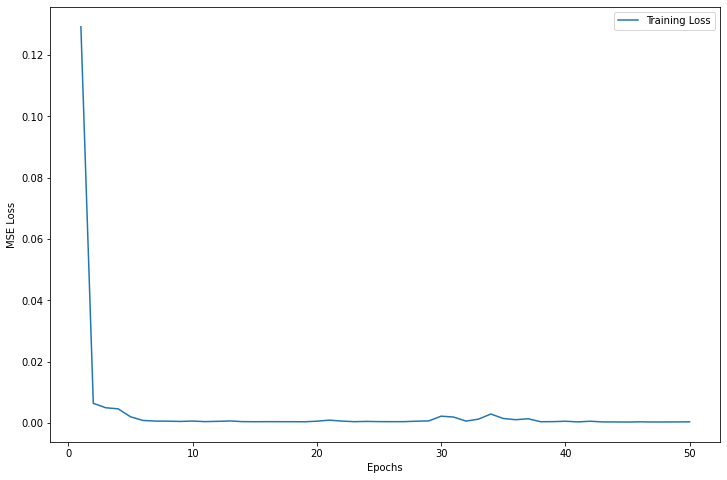

(1189, 1)
(764, 1)


Close         Pred
Date                            
2019-05-07   169.80   147.584763
2019-05-08   170.95   148.632690
2019-05-09   170.29   149.428375
2019-05-10   173.14   149.975861
2019-05-11   194.30   150.770798
...             ...          ...
2021-06-04  2688.19  2371.584961
2021-06-05  2630.58  2378.251709
2021-06-06  2715.09  2367.639404
2021-06-07  2590.26  2371.985352
2021-06-08  2517.44  2375.576660

[764 rows x 2 columns]

RMSE = 180.6348012760998


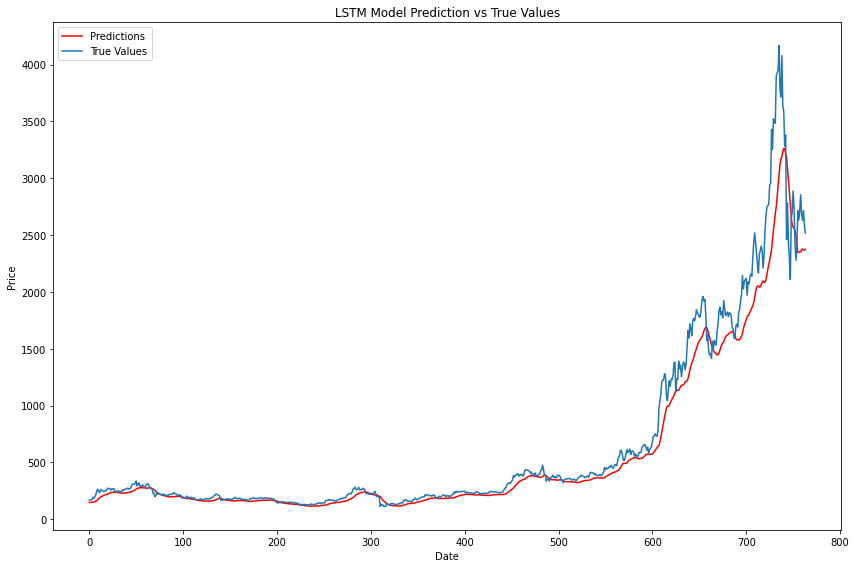

In [31]:
# Model 5


# Create the model!
from keras.layers import Dropout
model5 = Sequential()
model5.add(LSTM(2048, return_sequences=True,
                  input_shape=(19,2), dropout=0.2))
# model5.add(Dropout(0.2))
model5.add(LSTM(2048, return_sequences=True, dropout=0.2))
# model5.add(Dropout(0.2))
model5.add(LSTM(2048, return_sequences=False, dropout=0.2))
# model5.add(Dropout(0.2))
model5.add(Dense(units=1))

# Compile the model
model5.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model5.summary()

# Fit the model
history = model5.fit_generator(train_data, verbose=1, epochs=50)

# Plot loss by epoch
loss = history.history['loss']
epochs = range(1, len(history.history['loss'])+1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss)
plt.legend(['Training Loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show();

# Predict
train_pred = model5.predict_generator(train_data)
test_pred = model5.predict_generator(test_data)

# Inverse the transformation we did earlier so we have the true values of the predictions
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Helper function
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

# Get the y values
train_output = get_y_from_generator(train_data)
test_output = get_y_from_generator(test_data)

# Reverse transform those
train_output = scaler.inverse_transform(train_output)
test_output = scaler.inverse_transform(test_output)


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_pred, label='Predictions', color='red')
ax.plot(test_output, label="True Values")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
ax.set_title('LSTM Model Prediction vs True Values')
plt.tight_layout()
plt.savefig('lstm')

# Show predictions and RMSE
rmse_df5 = pd.DataFrame(df['Close'], index=df.index[1369:])
rmse_df5['Pred'] = test_pred
display(rmse_df5)
rmse = math.sqrt(mean_squared_error(rmse_df5['Close'], rmse_df5['Pred']))
print(f'RMSE = {rmse}')

In [ ]:
display(rmse_df5)
investment = 1000
for index, pred in enumerate(rmse_df5['Pred']):
  if index==763:
    break
  elif rmse_df5['Pred'][int(index+1)] > pred:
    investment = investment + 250
  elif rmse_df5['Pred'][index+1] < pred:
    investment = investment * 0.97

investment


Close         Pred
Date                            
2019-05-07   169.80   237.041687
2019-05-08   170.95   238.547897
2019-05-09   170.29   240.021545
2019-05-10   173.14   241.214935
2019-05-11   194.30   242.623917
...             ...          ...
2021-06-04  2688.19  2846.021484
2021-06-05  2630.58  2857.681641
2021-06-06  2715.09  2853.877686
2021-06-07  2590.26  2859.284912
2021-06-08  2517.44  2853.440430

[764 rows x 2 columns]

16861.630426920015

## Profit/Revenue Calculations

Now that the models have been constructed, let's calculate the net revnue made from three different trading strategies:

1. LSTM strategy
  - This strategy consists of the trader buying $250 worth of Ethereum on the day before a predicted rise in price, and then selling 3% worth of their total Ethereum on the day before a predicted fall.

2. Moving Average Strategy

3. Buy and Hold Strategy